This notebook trains an autoencoder on synthetic documents produced from the first 1e8 bytes (approximately 17mm words) of Wikipedia.

In [1]:
# https://github.com/ipython/ipykernel/issues/111
# Create logger
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import sys # create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)-15s : %(levelname)s : %(message)s') # - %(name)s %(clientip)s %(user)-8s
handler.setFormatter(formatter) # create formatter and add it to the handler
logger.handlers = [handler] # set STDERR handler as the only handler
logging.info('begin')

2017-04-28 13:29:29,034 : INFO : begin


In [2]:
import numpy as np
from scipy.stats import skew  # surprising this isn't in numpy
import tensorflow as tf
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)

In [3]:
# major inputs to this notebook
AGGREGATE_OOV = False  # skip out of vocabulary words when computing aggregate word counts (or softhots)
NUM_DOCUMENTS = 1000  # generate (at most) this many documents...
MEAN_DOC_SIZE = 300  # ...of this average size (log normal distribution; at size 300/380 only about 18441/14605 docs can be generated from text8.zip)
NUM_EPOCHS = 70  # number of training epochs
VOCAB_MAGNITUDE = 5000  # size of vocabulary

## Vocabulary Construction

In [4]:
import os
from zipfile import ZipFile
#from nltk.stem import LancasterStemmer # http://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg
from tfae.nlputils import corpus_stemmer
from tfae.nlputils import doc
reload(corpus_stemmer)
reload(doc)

# count the number of occurrences of each word in text8.zip
zipfile = 'text8'
zippath = os.path.join(os.getcwd(), 'data', 'word2vec_data', zipfile + '.zip')  # Linux
if not os.path.isfile(zippath):
    zippath = os.path.join(os.getcwd(), '..', 'word2vec', 'data', zipfile + '.zip')  # Windows

try:
    stemmer = corpus_stemmer.CorpusStemmer.load()
except (FileNotFoundError, json.JSONDecodeError):
    logging.debug('Unable to load CorpusStemmer from file {}; constructing from wordcounts instead'.format(corpus_stemmer.CorpusStemmer._SERIALIZE_FILENAME))

    # get raw, unadulterated (i.e. no stemming and no stopwords) wordcounts
    logging.debug('Opening ZipFile({})'.format(self._path))
    with ZipFile(zippath) as zf, zf.open(zipfile) as fp:
        cw0 = doc.count_words(fp, stemmer=None, is_stopword_pred=lambda w: False)
    unstemmed_wordcounts = cw0[0]

    # former todo comment from below: Probably should scrap usage of SoftHot after CorpusStemmer is
    # introduced--or at least make it configurable to switch back and forth between SoftHot and BoW,
    # which it now is (see word_count_vectorizers)
    stemmer = corpus_stemmer.CorpusStemmer(unstemmed_wordcounts)
    stemmer.dump()

2017-04-28 13:29:30,185 : INFO : tf_autoencoder imported
2017-04-28 13:29:30,334 : DEBUG : Loading CorpusStemmer from file /home/fred/code/tf_autoencoder/tfae/nlputils/resources/corpus_stemmer.pkl
2017-04-28 13:29:31,339 : DEBUG : Done loading CorpusStemmer (should take around 1 sec)


In [5]:
logging.debug('begin')
import pickle

# a few (6) of the constant stopwords map to the same stem
stemmed_constant_stopwords = set(stemmer.stem(w) for w in doc.STOPWORDS)
is_stopword_ntbk = lambda w: w in stemmed_constant_stopwords or stemmer.is_stopword(w, is_token_stemmed=True)

# re-count words with the stemmer
fname = os.path.join('data', '20170307-SemanticSearch-count_words.pkl')
if os.path.isfile(fname):
    with open(fname, 'rb') as f:
        logging.debug('Loading {}'.format(fname))
        cw1 = pickle.load(f)
else:
    logging.debug('Processing and dumping to {}'.format(fname))
    with ZipFile(zippath) as zf, zf.open(zipfile) as fp:
        cw1 = doc.count_words(fp, stemmer=stemmer, is_stopword_pred=is_stopword_ntbk)  # ~19 seconds in nosetests
    with open(fname, 'wb') as f:
        pickle.dump(cw1, f)
        
wordcounts, nwords, nwords_norepeat, nwords_nostops = cw1
assert('classified' not in wordcounts)

# 17,005,207 words in text8.zip (253,854 unique, 16,794,078 w/out consecutive repeats)
print('zippath = {}'.format(zippath))
print('nwords = {}, nwords_norepeat = {}, nwords_nostops = {}, nunique = {}'.format(nwords, nwords_norepeat, nwords_nostops, len(wordcounts)))
for w in ('', 'the', 'has', 'anarchy', 'anarchism', 'cdq', 'pattern', 'society', 'classified'):
    stemmed = stemmer.stem(w)
    print('count({}/{}) = {}'.format(w, stemmed, wordcounts[stemmed] if stemmed in wordcounts else 0))
logging.debug('end')

2017-04-28 13:29:31,360 : DEBUG : begin
2017-04-28 13:29:31,362 : DEBUG : Loading data/20170307-SemanticSearch-count_words.pkl
2017-04-28 13:29:31,406 : DEBUG : end


zippath = /home/fred/Documents/code/notebooks/data/word2vec_data/text8.zip
nwords = 16789212, nwords_norepeat = 17005207, nwords_nostops = 8552136, nunique = 156322
count(/) = 0
count(the/the) = 1061368
count(has/ha) = 38205
count(anarchy/anarc) = 1276
count(anarchism/anarc) = 1276
count(cdq/cdq) = 1
count(pattern/patern) = 1860
count(society/societi) = 4889
count(classified/clasif) = 1853


In [6]:
print(stemmer.stem('classified'))
print(wordcounts.get(stemmer.stem('classified'), None))  # <- should be 1853
print(wordcounts.get('classified', None))  # <- should be None

clasif
1853
None


In [7]:
vocab, sortedcounts = doc.construct_vocabulary(VOCAB_MAGNITUDE, wordcounts,
                                               is_stopword_pred=is_stopword_ntbk)

# 'th' is the top because lots of words like 'fifth' are split into 'five' and 'th'
print('top vocab:\n  {}\n'.format([(w, int(1/invc)) for invc, w  in sortedcounts[:15]]))
print('bottom vocab:\n  {}\n'.format([(w, int(1/invc)) for invc, w  in sortedcounts[VOCAB_MAGNITUDE-5:VOCAB_MAGNITUDE]]))

# a few (6) of the constant stopwords map to the same stem
print('Number of (unstemmed) constant stopwords: {}'.format(len(doc.STOPWORDS)))
print('Number of (stemmed) constant stopwords: {}'.format(len(stemmed_constant_stopwords)))
print('Number of (stemmed) constant stopwords in wordcounts: {} (should be the same)'.format(len([w for w in wordcounts.keys() if w in stemmed_constant_stopwords])))
print('Number of (stemmed) stemmer stopwords in wordcounts: {} (should be {})'.format(len([w for w in wordcounts.keys() if stemmer.is_stopword(w, is_token_stemmed=True)]), corpus_stemmer.CorpusStemmer.N_STOPWORDS))
print('Number of (stemmed) unioned stopwords in wordcounts: {}'.format(sum(1 for w in wordcounts.keys() if is_stopword_ntbk(w))))

top vocab:
  [('th', 13385), ('throu', 13250), ('later', 13002), ('state', 12923), ('histori', 12828), ('countri', 12706), ('governm', 12697), ('group', 12569), ('being', 12552), ('up', 12548), ('god', 12504), ('develo', 12301), ('high', 12238), ('centur', 12166), ('large', 12115)]

bottom vocab:
  [('repli', 261), ('silico', 261), ('ascen', 260), ('baco', 260), ('cher', 260)]

Number of (unstemmed) constant stopwords: 122
Number of (stemmed) constant stopwords: 116
Number of (stemmed) constant stopwords in wordcounts: 116 (should be the same)
Number of (stemmed) stemmer stopwords in wordcounts: 100 (should be 100)
Number of (stemmed) unioned stopwords in wordcounts: 158


## Document Vectorization

In [8]:
from tfae.nlputils import vectorizer
reload(vectorizer)

# softhot-computing functor OR just use WordCountVectorizer
#word_count_vectorizer = vectorizer.SoftHot(vocab)  # softhot probably not such a good idea now that using a stemmer
word_count_vectorizer = vectorizer.WordCountVectorizer(vocab)
mincount = int(1/sortedcounts[VOCAB_MAGNITUDE-1][0])
agg_wc_vec = word_count_vectorizer.aggregate(wordcounts, logging_words={'cdq', vocab[0]})



# TODO: generate `agg_wc_vec` using TensorFlow so that `doccounts` and `idf1` computations can be corrected



print('word_count_vectorizer.vmag = {}'.format(word_count_vectorizer.vmag))
print('final agg_wc_vec: mean = {:.3f}, stdev = {:.2f}, 25th/median/75th = {:.1f}/{:.1f}/{:.1f}'.format(np.mean(agg_wc_vec), np.std(agg_wc_vec), np.percentile(agg_wc_vec, 25), np.median(agg_wc_vec), np.percentile(agg_wc_vec, 75)))
relcounts = [1/sc[0]/agg_wc_vec[i] for i, sc in enumerate(sortedcounts[:VOCAB_MAGNITUDE])]
print('final relcounts: mean = {:.3f}, median = {:.3f}, stdev = {:.3f}'.format(np.mean(relcounts), np.median(relcounts), np.std(relcounts)))
print('selected old/new counts:')
for i in (0, 1, 2, VOCAB_MAGNITUDE-3, VOCAB_MAGNITUDE-2, VOCAB_MAGNITUDE-1):
    sc = sortedcounts[i]
    awv = agg_wc_vec[i]  # these should all be 1 when using wordcount vecs, but not when using softhots
    print('  [{}]({}) = {}/{:.3f} = {:.3f}'.format(i, sc[1], int(1/sc[0]), awv, 1/sc[0]/awv))

2017-04-28 13:29:43,295 : DEBUG : query word (96781) = "th"
2017-04-28 13:29:43,296 : DEBUG :   vec[:10] = [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] (sum = 1.0)
2017-04-28 13:29:43,296 : DEBUG :   mean = 0.0002, median = 0.0, stdev = 0.014140721339450825
2017-04-28 13:29:43,297 : DEBUG :   max = 1.0, argmax = "th"
2017-04-28 13:29:43,687 : DEBUG : query word (126059) = "cdq"
2017-04-28 13:29:43,688 : DEBUG :   vec[:10] = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] (sum = 0.0)
2017-04-28 13:29:43,689 : DEBUG :   mean = 0.0, median = 0.0, stdev = 0.0
2017-04-28 13:29:43,689 : DEBUG :   max = 0.0, argmax = "th"


word_count_vectorizer.vmag = 5000
final agg_wc_vec: mean = 1412.138, stdev = 1820.63, 25th/median/75th = 400.0/720.0/1595.2
final relcounts: mean = 1.000, median = 1.000, stdev = 0.000
selected old/new counts:
  [0](th) = 13385/13385.000 = 1.000
  [1](throu) = 13250/13250.000 = 1.000
  [2](later) = 13002/13002.000 = 1.000
  [4997](ascen) = 260/260.000 = 1.000
  [4998](baco) = 260/260.000 = 1.000
  [4999](cher) = 260/260.000 = 1.000


In [9]:
from zipfile import ZipFile

# test construction of just 2 documents, about 4 words each
with ZipFile(zippath) as zf, zf.open(zipfile) as fp:
    r = doc.construct_docs(fp, 2, word_count_vectorizer,
                           avgsz=np.log(4), stdsz=0, stemmer=stemmer)

def doctext2stopcount(doctext):
    """Prints enhanced document text, original words, their stems, whether or not they
    are stopwords or OOV, and their count according to the stemmer.
    """
    str = ''
    for w in doctext.split():
        stemmed = stemmer.stem(w)
        in_vocab = word_count_vectorizer.in_vocab(stemmed)
        stopstr = 'STOP' if is_stopword_ntbk(stemmed) else 'OOV' if not in_vocab else ''
        str += ' {}/{}/{}/{}'.format(w, stemmed, stopstr, stemmer.corpus_count(w))
    return str

for i in range(2):
    print('i={}, wordcount={}, doctext="{}"'.format(i, dict(r[1][i]), r[2][i]))
    print(' {}\n'.format(doctext2stopcount(r[2][i])))

2017-04-28 13:29:44,145 : INFO : First 10 docsizes (out of 2): [4, 4]


i=0, wordcount={'anarc': 1, 'abus': 1, 'origina': 1, 'term': 1}, doctext=" anarchism originated as a term of abuse"
  anarchism/anarc//1287 originated/origina//1102 as/as/STOP/131889 a/a/STOP/325801 term/term//11209 of/of/STOP/598145 abuse/abus//928

i=1, wordcount={'radica': 1, 'clas': 1, 'engl': 1, 'agains': 1}, doctext=" first used against early working class radicals including the diggers of the english"
  first/first/STOP/28886 used/used/STOP/22738 against/agains//8432 early/earli/STOP/13583 working/work/STOP/17947 class/clas//4663 radicals/radica//1041 including/includ/STOP/21948 the/the/STOP/1061370 diggers/dige/OOV/58 of/of/STOP/598145 the/the/STOP/1061370 english/engl//11861



In [10]:
from tfae.nlputils import norm
reload(norm)

# normalize each document's (softhot-based) BM25 vector s.t. this percentile is equal to
# 1.0 (used in assorted log messages; probably best to use with softhot inputs)
# note that this is a percentile of the vocabulary size, so it is effectively the same as
# NORM_NEG_PARTITION_IDX = 0.005 * VOCAB_MAGNITUDE (e.g. 0.005 * 3000 = 15)
NORM_PERCENTILE = 99.5

# normalize based on this percentile of the non-zero values only (allows for documents with lots of
# repeated words to still stand out, while at the same time controls for document size)
NORM_NONZERO_PERCENTILE = 50

# normalize each document's wordcount vector s.t. the second largest value is equal to 1.0,
# this value gets negated in `nth_largest` below, which is why -2 corresponds to the second largest
NORM_NEG_PARTITION_IDX = 26

# whatever normalization strategy is chosen, it seems like the values need to *approximately*
# end up between 0 and 1 for the VAE to function properly (TODO: figure out why this is)
NORM_STRATEGY = norm.NormStrategy.NONE

NORM_STRATEGY_2_PARAMETER = {norm.NormStrategy.PERCENTILE: NORM_PERCENTILE,
                             norm.NormStrategy.NONZERO_PERCENTILE: NORM_NONZERO_PERCENTILE,
                             norm.NormStrategy.INDEX: NORM_NEG_PARTITION_IDX}

In [11]:
# define some functions used in the following cells
def stats_str(v, dfmt='{:.3f}', print_argmax=True):
    if len(np.array(v).shape) != 1:
        raise ValueError('stats_str `v` shape must be 1-D; v.shape={}'.format(np.array(v).shape))
    vfmt = 'mean=' + dfmt + ', stdev=' + dfmt + ', skew=' + dfmt + ', 25th/median/75th/95th/{}th percentiles=' + dfmt + '/' + dfmt + '/' + dfmt + '/' + dfmt + '/' + dfmt + ', {}th largest=' + dfmt + ', max=' + dfmt + ', argmax="{}"'    
    return vfmt.format(np.mean(v), np.std(v), skew(v), NORM_PERCENTILE, np.percentile(v, 25), np.median(v), np.percentile(v, 75), np.percentile(v, 95), np.percentile(v, NORM_PERCENTILE), norm.NTH_LARGEST_DEFAULT_N, norm.nth_largest(v), np.max(v), vocab[np.argmax(v)] if print_argmax else 'N/A')

2017-04-28 13:29:44,605 : INFO : First 10 docsizes (out of 1): [299]


w[ 218]="act"          , count= 1, wc_vec= 1.0, idf0e2= 5.6, idf1= 9.0, tfidf= 9.0, bm25= 9.0
w[1416]="pries"        , count= 1, wc_vec= 1.0, idf0e2=21.5, idf1=10.2, tfidf=10.2, bm25=10.2
w[  26]="found"        , count= 3, wc_vec= 3.0, idf0e2= 2.7, idf1= 8.3, tfidf=14.3, bm25=11.8
w[  27]="term"         , count= 5, wc_vec= 5.0, idf0e2= 2.7, idf1= 8.3, tfidf=18.5, bm25=12.9
w[ 613]="self"         , count= 4, wc_vec= 4.0, idf0e2=10.4, idf1= 9.6, tfidf=19.1, bm25=14.4
w[ 349]="text"         , count= 1, wc_vec= 1.0, idf0e2= 7.2, idf1= 9.2, tfidf= 9.2, bm25= 9.2
w[1536]="anarc"        , count=26, wc_vec=26.0, idf0e2=23.5, idf1=10.3, tfidf=52.4, bm25=17.9
w[ 251]="exist"        , count= 1, wc_vec= 1.0, idf0e2= 6.0, idf1= 9.1, tfidf= 9.1, bm25= 9.1
w[ 452]="ancie"        , count= 1, wc_vec= 1.0, idf0e2= 8.4, idf1= 9.4, tfidf= 9.4, bm25= 9.4
w[ 176]="someti"       , count= 1, wc_vec= 1.0, idf0e2= 5.0, idf1= 8.9, tfidf= 8.9, bm25= 8.9

document word count vector: mean=0.060, stdev=0.491, skew=3

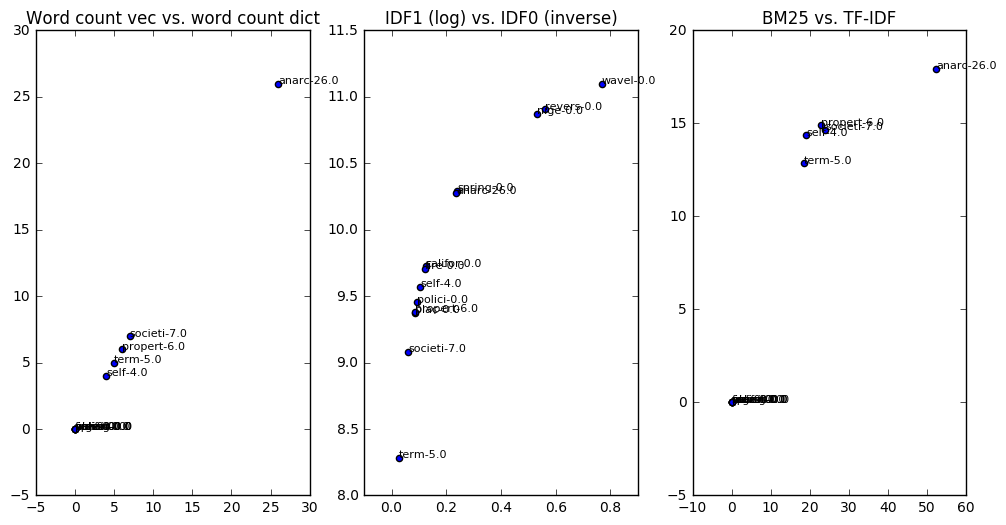

In [12]:
from tfae.nlputils import plot
reload(norm)
reload(plot)

# every `docsize` (300) words is a new document
docsize = MEAN_DOC_SIZE
with ZipFile(zippath) as zf, zf.open(zipfile) as fp:
    adoc = doc.construct_docs(fp, 1, word_count_vectorizer,
                              avgsz=np.log(docsize), stdsz=0, stemmer=stemmer)
doc_wc_vec, docwordcounts = adoc[0][0], adoc[1][0]

# un-scale?
#doc_wc_vec *= max(docwordcounts.values())

# calculate IDF for each word
idf1_ndocs = nwords / docsize  # number of documents for idf1 purposes
doccounts = agg_wc_vec / docsize  # agg_wc_vec ignores docs, so divide by docsize to get approx. doc count
idf0 = np.where(doccounts == 0, 1.0, 1.0 / doccounts)  # if you use agg_wc_vec here rather than doccounts then idf1 can go negative
idf1 = 1.0 + np.log(idf1_ndocs / (1.0 + doccounts))

# 2 different ways to compute document-word weights
doctfidfs = norm.tfidf_weight(doc_wc_vec, idf1)
docbm25s = norm.bm25_weight(doc_wc_vec, idf1, docsize, B=0.5, K1=0.8)  # before scaling in construct_docs: B=0.5, K1=0.8
# NOTE: docbm25s are not normalized

for j, (w, c) in enumerate(docwordcounts.items()):
    try: i = vocab.index(w)
    except: print('w[----]={:15s}, count={:2d}, {}'.format('"'+w+'"', c, '<STOPWORD>' if is_stopword_ntbk(w) else '<OOV>'))
    else: print('w[{:4d}]={:15s}, count={:2d}, wc_vec={:4.1f}, idf0e2={:4.1f}, idf1={:4.1f}, tfidf={:4.1f}, bm25={:4.1f}'.format(i, '"'+w+'"', c, doc_wc_vec[i], idf0[i]*1e2, idf1[i], doctfidfs[i], docbm25s[i]))
    if j > 8: break

print('\ndocument word count vector: {}\n'.format(stats_str(doc_wc_vec)))

# the effect of the last plot was much more obvious when stop words were included (they
# fell below the trendline)
plot.plot_document(vocab, idf0, idf1, doc_wc_vec, doctfidfs, docbm25s)

In [13]:
# it takes about 1.5 minutes to construct 200 documents of 300 words each (6 minutes for 800)
logging.info('begin')

# set lower_bound_size (only required when testing with a small MEAN_DOC_SIZE)
if NORM_STRATEGY == norm.NormStrategy.PERCENTILE:
    pct_required = 100 - NORM_PERCENTILE
    lower_bound_size = int(pct_required / 100 * VOCAB_MAGNITUDE + 0.5)
elif NORM_STRATEGY == norm.NormStrategy.NONZERO_PERCENTILE:
    lower_bound_size = 4
elif NORM_STRATEGY == norm.NormStrategy.INDEX:
    lower_bound_size = NORM_NEG_PARTITION_IDX * 6
elif NORM_STRATEGY == norm.NormStrategy.SUM:
    lower_bound_size = 20
elif NORM_STRATEGY == norm.NormStrategy.NONE:
    lower_bound_size = 1
else:
    raise ValueError('Unknown NORM_STRATEGY='.format(NORM_STRATEGY))
    
# TODO: why not just normalize by docsize?  or wouldn't this be the same as normalizing the
# length of the vector to sum to 1
print('lower_bound_size: {}'.format(lower_bound_size))
print('MEAN_DOC_SIZE: {}'.format(MEAN_DOC_SIZE))

# as of 3/9/17 English Wikipedia has 5,350,632 articles and 2.9 billion words => mean=542,
# and median=280/416*542=365 perhaps (based on lognormal dist w/ mean 416 and median 280)
notebooks_dataroot = os.path.join(os.getcwd(), 'data')
rootpath = doc.rootpath_(notebooks_dataroot, '20170421_114058_m300_v5000')  # m and v are MEAN_DOC_SIZE and VOCAB_MAGNITUDE
if rootpath is None:
    with ZipFile(zippath) as zf, zf.open(zipfile) as fp:
        rootpath, NUM_DOCUMENTS = doc.construct_docs(fp, NUM_DOCUMENTS, word_count_vectorizer,
                                                     avgsz=np.log(MEAN_DOC_SIZE), stdsz=0.7, lbsz=lower_bound_size,
                                                     stemmer=stemmer,
                                                     outpath=notebooks_dataroot)
    # # lru_cache stats
    # # CacheInfo(hits=36359, misses=25848, maxsize=256, currsize=256) with NUM_DOCUMENTS=200 and avgsz=log(300)
    logging.debug(word_count_vectorizer.eval.cache_info())

print('rootpath: {}'.format(rootpath))
print('NUM_DOCUMENTS: {}'.format(NUM_DOCUMENTS))
logging.info('end')

2017-04-28 13:29:45,624 : INFO : begin
2017-04-28 13:29:45,625 : INFO : end


lower_bound_size: 1
MEAN_DOC_SIZE: 300
rootpath: /home/fred/Documents/code/notebooks/data/docs/20170421_114058_m300_v5000
NUM_DOCUMENTS: 1000


In [15]:
# this doesn't seem to work: "Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.
# FailedPreconditionError'>, Attempting to use uninitialized value input_2/input_producer/limit_epochs/epochs"
#from tfae.mlutils import tfutils
#reload(tfutils)
#interactive_sess = tfutils.initialize_session(interactive=True)

In [16]:
from tfae.mlutils import tfutils
reload(doc)
reload(tfutils)

#with tf.Graph().as_default(): # <- doesn't seem to matter if this is here or not
a, b, c = 3, 1, 100
wc_vecs_ = doc.tf_generate_docs(batch_size=a, n_epochs=b, rootpath=rootpath,
                               n_docs=c, n_vocab=VOCAB_MAGNITUDE, shuffle=False)
wc_vec_values = tfutils.coord_eval([wc_vecs_, tf.shape(wc_vecs_)])
print('shape of each batch (should be {}x{}): {}'.format(3, VOCAB_MAGNITUDE, wc_vec_values[1][0]))
wc_vec_values = [v for batch in wc_vec_values[0] for v in batch]  # de-batch
try: assert(b * c - a < len(wc_vec_values) and len(wc_vec_values) <= b * c)
except: logging.error('{} != {}'.format(len(wc_vec_values), b * c))

docsizes = np.array([np.sum(v) for v in wc_vec_values], dtype=int)
#median_docsize = np.median(docsizes)
print('first 10 (out of {}) docsizes (not shuffled): {}'.format(len(wc_vec_values), docsizes[:10]))
print('docsizes: {}\n'.format(stats_str(docsizes, dfmt='{:.0f}', print_argmax=False)))

first = wc_vec_values[0]
print('first word count vec: {}\n'.format(stats_str(first)))
print('aggregate wc vec: {}\n'.format(stats_str(agg_wc_vec, dfmt='{:.0f}')))
logging.info('end')

2017-04-28 13:31:14,169 : DEBUG : Constructing string_input_producer with 100 filenames
2017-04-28 13:31:14,203 : DEBUG : tf_generate_docs.output_tensors = Tensor("tf_generate_docs/batch:0", shape=(3, 5000), dtype=float64)
2017-04-28 13:31:14,295 : DEBUG : log_default_graph(stack_index=2): coord_eval: using TensorFlow default graph with id 140258496349464
2017-04-28 13:31:14,319 : INFO : end


shape of each batch (should be 3x5000): [   3 5000]
first 10 (out of 99) docsizes (not shuffled): [1031  396  595 1440 1108  151  583  269  279  399]
docsizes: mean=399, stdev=299, skew=2, 25th/median/75th/95th/99.5th percentiles=190/314/505/1053/1455, 2th largest=1440, max=1469, argmax="N/A"

first word count vec: mean=0.206, stdev=1.274, skew=32.594, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/1.000/5.005, 2th largest=16.000, max=68.000, argmax="anarc"

aggregate wc vec: mean=1412, stdev=1821, skew=3, 25th/median/75th/95th/99.5th percentiles=400/720/1595/5026/11261, 2th largest=13250, max=13385, argmax="th"



In [17]:
# must use (global) default graph for wc_vecs0 b/c it's used in the next cell
wc_vecs0 = doc.tf_generate_docs(batch_size=100, n_epochs=1, rootpath=rootpath,
                               n_docs=1000, n_vocab=VOCAB_MAGNITUDE, shuffle=False)
tf_docsizes = tfutils.coord_eval([tf.cast(tf.reduce_sum(wc_vecs0, axis=1), tf.int32)])

# tf.zeros([tf.shape(wc_vecs)[0]], dtype=tf.int32)
tf_docsizes = tf_docsizes[0]  # we only care about the first tensor b/c there's only 1
tf_docsizes = [v for batch in tf_docsizes for v in batch]  # de-batch
print('first 10 (out of {}) tf_docsizes (not shuffled): {}'.format(len(tf_docsizes), tf_docsizes[:10]))
median_docsize = np.median(tf_docsizes)
print('Median document size {} should be just a bit lower than {}'.format(median_docsize, MEAN_DOC_SIZE))
logging.debug('end')

2017-04-28 13:31:17,645 : DEBUG : Constructing string_input_producer with 1000 filenames
2017-04-28 13:31:17,674 : DEBUG : tf_generate_docs.output_tensors = Tensor("tf_generate_docs_1/batch:0", shape=(100, 5000), dtype=float64)
2017-04-28 13:31:17,709 : DEBUG : log_default_graph(stack_index=2): coord_eval: using TensorFlow default graph with id 140258496349464
2017-04-28 13:31:17,821 : DEBUG : end


first 10 (out of 1000) tf_docsizes (not shuffled): [1031, 396, 595, 1440, 1108, 151, 583, 269, 279, 399]
Median document size 287.5 should be just a bit lower than 300


In [18]:
reload(norm)
reload(tfutils)

bm25_vecs0 = norm.bm25_weight(wc_vecs0, idf1, median_docsize, B=0.5, K1=0.8)
with tfutils.initialize_session():
    bm25_vec_values = tfutils.coord_eval([bm25_vecs0])[0]
bm25_vec_values = [v for batch in bm25_vec_values for v in batch]  # de-batch

bm25sizes = np.array([np.sum(v) for v in bm25_vec_values], dtype=int)
np_sum = np.sum(norm.bm25_weight(wc_vec_values[0], idf1, median_docsize, B=0.5, K1=0.8))
print('first 10 (out of {}) bm25sizes (first should be {}): {}\n'.format(len(bm25_vec_values), int(np_sum), bm25sizes[:10]))
print('bm25sizes: {}\n'.format(stats_str(bm25sizes, dfmt='{:.0f}', print_argmax=False)))
print('first BM25 vec: {}\n'.format(stats_str(bm25_vec_values[0])))

2017-04-28 13:31:20,948 : DEBUG : log_default_graph(stack_index=2): <module>: using TensorFlow default graph with id 140258496349464
2017-04-28 13:31:20,982 : DEBUG : log_default_graph(stack_index=2): coord_eval: using TensorFlow default graph with id 140258496349464


first 10 (out of 1000) bm25sizes (first should be 3921): [3921 2266 2861 4715 3903 1298 3079 1828 1690 2441]

bm25sizes: mean=2139, stdev=972, skew=1, 25th/median/75th/95th/99.5th percentiles=1410/1993/2720/3974/5177, 2th largest=5446, max=5765, argmax="N/A"

first BM25 vec: mean=0.784, stdev=2.468, skew=3.207, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/6.744/12.019, 2th largest=17.146, max=18.007, argmax="anarc"



2017-04-28 13:31:23,938 : DEBUG : log_default_graph(stack_index=2): <module>: using TensorFlow default graph with id 140258496349464
2017-04-28 13:31:23,972 : DEBUG : log_default_graph(stack_index=2): coord_eval: using TensorFlow default graph with id 140258496349464


first bm25 vec (pre normalization): mean=0.784, stdev=2.468, skew=3.207, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/6.744/12.019, 2th largest=17.146, max=18.007, argmax="anarc"

first bm25 sum: 3921.7352721249244 (np) ==? 3921.7352721249244 (tf)

first bm25 vec (post normalization): mean=0.784, stdev=2.468, skew=3.207, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/6.744/12.019, 2th largest=17.146, max=18.007, argmax="anarc"



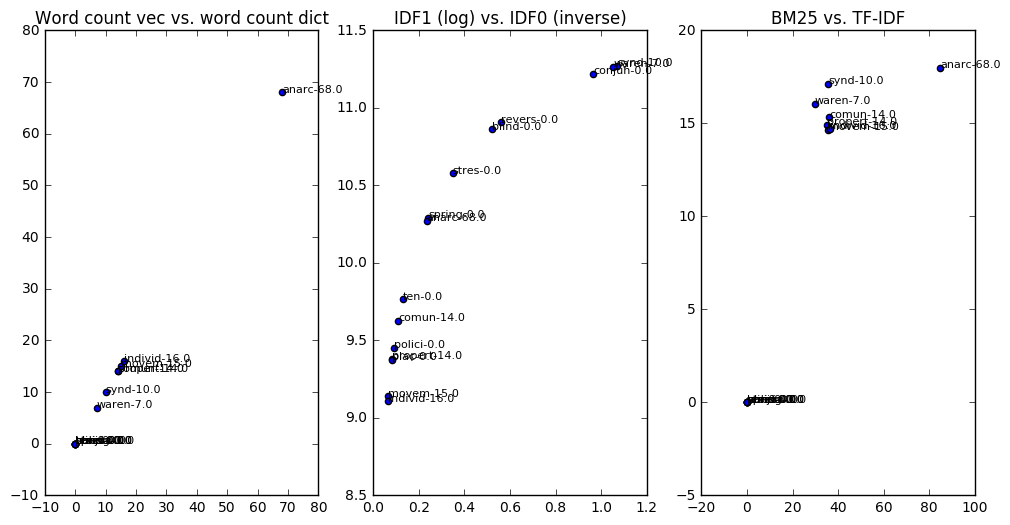

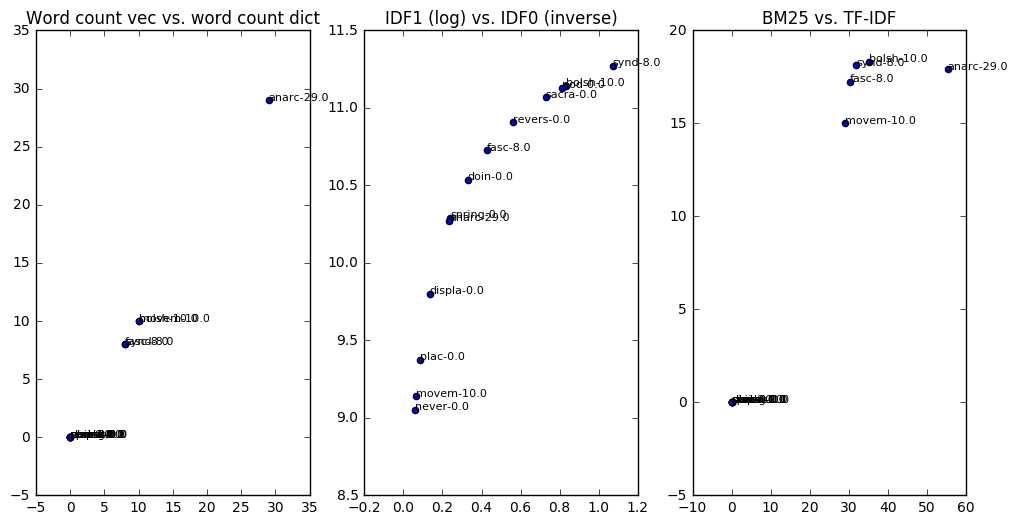

In [19]:
from tfae.datasets import vector
reload(plot)
reload(norm)
reload(vector)

# compute BM25 vectors for each document (and normalize them)
# "word counts are scaled to decimals between 0 and 1"
# [https://deeplearning4j.org/deepautoencoder#topic-modeling--information-retrieval-ir]
print('first bm25 vec (pre normalization): {}\n'.format(stats_str(bm25_vec_values[0])))
normparam = NORM_STRATEGY_2_PARAMETER.get(NORM_STRATEGY, None)
nlizer = norm.construct_bm25_normalizer(bm25_vec_values, NORM_STRATEGY, normparam, tf_docsizes)
if nlizer.norm_strategy != NORM_STRATEGY:
    logging.info('Using NormStrategy {} (with parameter={}) in place of {}'.format(nlizer.norm_strategy, nlizer.parameter, NORM_STRATEGY))
np_bm25s = [nlizer(v) for v in bm25_vec_values]

# if `tf_normalize_bm25s` is working then `nth_largest` must be also (so no need to check)
# nths = norm.nth_largest(bm25_vecs, n=nlizer.parameter)
# first_nth_value = tfutils.coord_eval([nths])[0][0][0][0]  # first variable, batch, datapoint, value
# print('{} ==? {}\n'.format(norm.nth_largest(bm25_vec_values[0], nlizer.parameter), first_nth_value))

bm25_norms0 = norm.tf_normalize_bm25s(bm25_vecs0, nlizer.norm_strategy, nlizer.parameter)
with tfutils.initialize_session():
    bm25_norm_values = tfutils.coord_eval([bm25_norms0])[0][0]  # first variable, batch
print('first bm25 sum: {} (np) ==? {} (tf)\n'.format(np.sum(np_bm25s[0]), np.sum(bm25_norm_values[0])))

first = bm25_norm_values[0]
# set dfmt='{}' to avoid this error "TypeError: non-empty format string passed to object.__format__"
print('first bm25 vec (post normalization): {}\n'.format(stats_str(first)))

for i in [0, 1]:
    plot.plot_document(vocab, idf0, idf1, wc_vec_values[i], norm.tfidf_weight(wc_vec_values[i], idf1), bm25_norm_values[i])

## Dimensionality Reduction

The dimensionality of latent space, `nz` in the next cell, can be thought of as the number of clusters that the input is being compressed down in to.  In other words, the compression ratio is `VOCAB_MAGNITUDE/nz`.  Another way to accomplish similar such clustering would be by the k-means algorithm with exactly that same number, `nz`, of clusters.  It could even be done hierarchically, analogously to the network architecture being used below, by first setting k=`nh1` then re-clustering each of those with k=`nh2/nh1` (or something like that).

The advantage of using an autoencoder is that the function space can be more continuous and less piecewise.

This informs the purpose of stemming.  Stemming isn't meant to convert all words of similar meaning to the same word.  Indeed it's not meant to do anything semantic; that's what the autoencoder is for.  It's only meant to reduce the dimensionality by a little so that the autoencoder has a good input representation to chew on.

TODO: After encoding run k-means clustering to deterime representative values for each of the clusters.  Encoding seems to separate points in space but it doesn't do so in a way s.t. you end up with 1-hot vectors.  k-means clustering is a way to transform or rotate axes (perhaps) that converts back to 1-hot and from there representative samples (or *explanations*) can be assigned to each bit of the 1-hot.

In [20]:
reload(doc)
reload(norm)

# training/validation data separator (every 20th document will be a validation doc)
tr_va_mod = 20

# training data
logging.debug('Training data')
batch_size = int(min(100, NUM_DOCUMENTS/2-1))
wc_vecs = doc.tf_generate_docs(batch_size, NUM_EPOCHS, rootpath, NUM_DOCUMENTS, VOCAB_MAGNITUDE, True,
                               exclude_mod=tr_va_mod)
@tfutils.name_scope
def preprocess(wc_vecs):
    bm25_vecs = norm.bm25_weight(wc_vecs, idf1, median_docsize, B=0.5, K1=0.8)
    bm25_norms = norm.tf_normalize_bm25s(bm25_vecs, nlizer.norm_strategy, nlizer.parameter)
    return bm25_norms
bm25_norms = preprocess(wc_vecs)

# validation data (vadata_size: batch_size should equal n_docs as tf_train only runs one step)
logging.debug('Validation data')
vadata_size = 400
va_wc_vecs = doc.tf_generate_docs(vadata_size, -1, rootpath, vadata_size, VOCAB_MAGNITUDE, True,
                                  include_mod=tr_va_mod)
va_bm25_norms = preprocess(va_wc_vecs)

# float32 seems to be the default (e.g. https://www.tensorflow.org/api_docs/python/tf/random_uniform)
trdata = tf.cast(bm25_norms, tf.float32)
vadata = tf.cast(va_bm25_norms, tf.float32)

2017-04-28 13:31:29,293 : DEBUG : Training data
2017-04-28 13:31:29,465 : DEBUG : Constructing string_input_producer with 1000 filenames
2017-04-28 13:31:29,498 : DEBUG : tf_generate_docs.output_tensors = Tensor("tf_generate_docs_2/shuffle_batch:0", shape=(100, 5000), dtype=float64)
2017-04-28 13:31:29,509 : DEBUG : Validation data
2017-04-28 13:31:29,676 : DEBUG : Constructing string_input_producer with 400 filenames
2017-04-28 13:31:29,704 : DEBUG : tf_generate_docs.output_tensors = Tensor("tf_generate_docs_3/shuffle_batch:0", shape=(400, 5000), dtype=float64)


In [21]:
from tfae import vae
from tfae import train
reload(vae)
reload(train)
reload(tfutils)

# the original MNIST notebook uses 500/500/20 for these values
nh1 = int(VOCAB_MAGNITUDE/2) #600 #int(vmag/10)  # 1/10 of n_input? as suggested here: https://hal.inria.fr/hal-01256422v1/document
nh2 = int(VOCAB_MAGNITUDE/4) #400 # int(vmag/12)  # 1/12 of n_input? as suggested in same paper (except that this is their central layer!)
nz  = int(VOCAB_MAGNITUDE/6) #50  # 20? or was it 200? suggested by same paper?

netarch = {'n_input':VOCAB_MAGNITUDE, # number of items (1m=3706, 100k=1682)
           'n_hidden_recog_1':nh1, # 1st layer encoder neurons
           'n_hidden_recog_2':nh2, # 2nd layer encoder neurons
           'n_z':nz,               # dimensionality of latent space
           'n_hidden_gener_1':nh2, # 1st layer decoder neurons
           'n_hidden_gener_2':nh1} # 2nd layer decoder neurons

# weights higher input values more (by 1+a*x) in loss fn
use_rmse = False
if use_rmse:
    mean_x_sum = np.mean(np.array([sum(v) for v in np_bm25s]))
    confidence_alpha = VOCAB_MAGNITUDE / MEAN_DOC_SIZE * 10  # multiplying by 50 gets this near 1000 (as if the 0s don't even exist)
    rmse_correction = 300 / confidence_alpha #/ mean_x_sum
    print('mean_x_sum = {}'.format(mean_x_sum))
    print('rmse_correction = {}'.format(rmse_correction))  # note that learning happens much faster at higher levels (similar to increasing learning_rate)
else:
    confidence_alpha = 1.0
    rmse_correction = None
print('confidence_alpha = {}'.format(confidence_alpha))
print('NORM_STRATEGY = {}'.format(nlizer.norm_strategy))

# some expectations:
# 1. Loss/cost should start around 5000 (for batch_size=100) and drop steadily over the epochs (if it
#     doesn't and `use_rmse` is True, then try adjusting `rmse_correction`).
# 2. When `use_rmse` is True the denoising loss should be a little higher than the corruption level
#     (e.g. 38% vs. 0.3), but not if `use_rmse` is False.
# 3. The latent loss should, at first, be optimized away, but then grow as the model switches to focusing
#     on reducing reconstruction loss.  If the latent loss peaks and then heads back down, this might also
#     be where the validation loss bottoms out.
# 4. if learning isn't happening (i.e. loss dropping) then the normalization could be wrong (e.g. values not
#     approximately between 0 and 1)
#tf.reset_default_graph()
untrained_vae = vae.VariationalAutoencoder(netarch,
                                           learning_rate=0.001,
                                           corruption_level=0.3,
                                           use_rmse=use_rmse,
                                           rmse_correction=rmse_correction,
                                           confidence_alpha=confidence_alpha,
                                           binarize_input=True)

writer_dirs = ['train', 'validate']
logpath = lambda k: os.path.join(os.getcwd(), 'logs', k)
summary_writers = {k: tf.summary.FileWriter(logpath(k), untrained_vae.graph) for k in writer_dirs}

print('batch_size = {}'.format(batch_size))
print('NUM_EPOCHS = {}'.format(NUM_EPOCHS))
batches_per_epoch = NUM_DOCUMENTS / batch_size
print('steps/batches per epoch = {}'.format(batches_per_epoch))
trained_vae = train.coord_train(untrained_vae, batches_per_epoch, trdata, summary_writers['train'],
                                vadata=vadata, va_summary_writer=summary_writers['validate'],
                                display_mod=10)

# TODO: rather than pretraining with RBMs why couldn't a NN be pre-trained with a linear (or any other)
# method?  e.g. run k-means clustering and then "encode" the output of that into the structure of the
# NN?  it's like progressively dumbing down from GAN -> supervised -> unsupervised -> pretraining ->
# Xavier initialization -- each previous, more simple pre-step has to be done first, in order before
# the more complex steps.  why can't a linear (or other non-NN) model be one of those steps?

2017-04-28 13:31:52,106 : DEBUG : log_default_graph(stack_index=1): __init__: using TensorFlow default graph with id 140258182429384


confidence_alpha = 1.0
NORM_STRATEGY = 0


/home/fred/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2017-04-28 13:31:53,403 : DEBUG : log_default_graph(stack_index=2): __init__: using TensorFlow default graph with id 140258182429384
2017-04-28 13:31:54,849 : DEBUG : log_default_graph(stack_index=2): coord_train: using TensorFlow default graph with id 140258496349464
2017-04-28 13:31:54,854 : DEBUG : log_default_graph(stack_index=1): coord_train: using TensorFlow default graph with id 140258496349464


batch_size = 100
NUM_EPOCHS = 70
steps/batches per epoch = 10.0


2017-04-28 13:31:55,956 : INFO : Epoch 0.0 (step 0.76 sec): loss=6164.3 (3862.8 +1665.8 +635.70; d=27%), valoss=5111.1
2017-04-28 13:31:56,283 : INFO : Epoch 0.1 (step 0.33 sec): loss=5022.2 (3165.1 +1367.8 +489.34; d=27%), valoss=5111.1
2017-04-28 13:31:56,637 : INFO : Epoch 0.2 (step 0.35 sec): loss=4074.7 (2781.1 +1189.3 +104.22; d=29%), valoss=5111.1
2017-04-28 13:31:56,998 : INFO : Epoch 0.3 (step 0.36 sec): loss=3992.1 (2784.8 +1182.6 +24.73; d=30%), valoss=5111.1
2017-04-28 13:31:57,355 : INFO : Epoch 0.4 (step 0.36 sec): loss=4039.9 (2824.7 +1207.1 +8.10; d=30%), valoss=5111.1
2017-04-28 13:31:57,714 : INFO : Epoch 0.5 (step 0.36 sec): loss=4005.1 (2803.6 +1198.1 +3.46; d=30%), valoss=5111.1
2017-04-28 13:31:58,075 : INFO : Epoch 0.6 (step 0.36 sec): loss=3805.0 (2670.2 +1133.0 +1.76; d=30%), valoss=5111.1
2017-04-28 13:31:58,425 : INFO : Epoch 0.7 (step 0.35 sec): loss=3695.7 (2590.6 +1104.0 +1.04; d=30%), valoss=5111.1
2017-04-28 13:32:30,401 : INFO : Epoch 10.0 (step 0.35 se

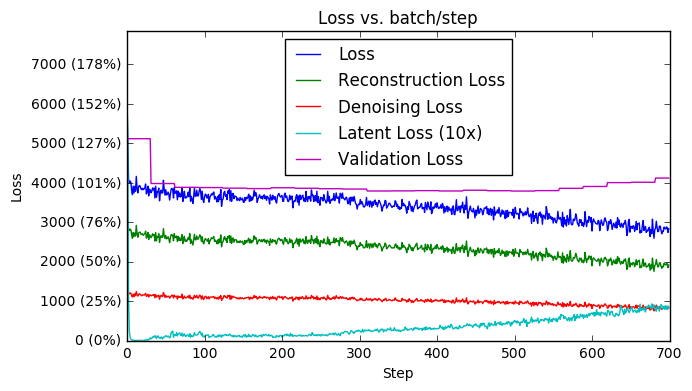

In [22]:
#trained_vae = untrained_vae

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.set_title('Loss vs. batch/step')

y = trained_vae.batch_losses[0]
#y = np.clip(trained_vae.batch_losses[0], 0, 200)
x = list(range(len(y)))
ax.plot(x, y, label='Loss')
ax.plot(x, np.array(trained_vae.batch_losses[1]), label='Reconstruction Loss')
ax.plot(x, np.array(trained_vae.batch_losses[2]), label='Denoising Loss')
ax.plot(x, np.array(trained_vae.batch_losses[3]) * 10, label='Latent Loss (10x)')
ax.plot(x, np.array(trained_vae.va_loss), label='Validation Loss')
#ax.plot(x, np.array(trained_vae.epoch_rmse) * rmse_correction * 100, label='Scaled RMSE')
#ax.plot(x, np.array(trained_vae.epoch_varmse) * rmse_correction * 100, label='Scaled Validation RMSE')
ax.set_ylabel('Loss')
ax.set_xlabel('Step')
rel = norm.nth_largest(y, n=10)
ax.set_ylim(0, 2 * rel)
ax.legend(loc='upper center')

# http://stackoverflow.com/questions/11244514/modify-tick-label-text
fig.canvas.draw()
pcts = []
for k in ax.get_yticklabels():
    try: pcts.append(int(float(k.get_text()) / rel * 100))
    except: pcts.append('pct')
labels = ['{} ({}%)'.format(k.get_text(), pct) for k, pct in zip(ax.get_yticklabels(), pcts)]
ax.set_yticklabels(labels);

### TODO: It's learning the low values really well, but the RMSE on the higher valued points, not so much.  Perhaps this is the time to switch to an implicit model with each error weighted by a confidence.
* Actually, around epoch 900 it's starting to focus more on the higher points, and at 1200 the RMSE on the lower points is actually ticking up a little in favor of the higher points.  I.e. SELECTION BIAS is the root of all evil.

## On the next cell:

#### On the bm25 input vector:
The next cell shows `mean(argmax_qbm25s)` which is a measure of how well the individual query words are accounted for in the bm25 vector.  The bm25 vector can be thought of as having a similar meaning to a word count vector, but if a query word isn't in the vocabulary (e.g. if using softhots in place of wordcounts) then its argmax in the bm25 vector won't be very high.  This is why the stemmer helps--because it gets more non-stemmed words effectively included in the vocabulary; i.e. the more coverage the vocabulary has, the better.

#### On the reconstructions:
It also shows that reconstruction is somewhat selecting for common query words.  Argmax reconstruction words are "two" and "three."  Perhaps the reconstructions need to be adjusted for common words similar to how IDF is used to adjust the input vectors?  This would neutralize away words common words like "two" and "three" perhaps.

In [28]:
from collections import defaultdict
reload(norm)
reload(tfutils)

# this cell doesn't need a `with sess.as_default()` because it doesn't call `coord_eval`,
# but the session used in this cell does need to be the same one used in the next cell
with tfutils.initialize_session() as sess:

    # even though 'anarchism' isn't in vocab, it still gets picked up by its Levenshtein
    # proximity to 'analysis' which is in the vocabulary (but w/ stemming this works even
    # better because 'anarch' is in the vocabulary => the more coverage the vocabulary has,
    # the better)
    query = 'anarchism originated term abuse'#'international shipping'#'washington'#
    stemmed_query = []
    for w in query.split():
        stemmed_query.append(stemmer.stem(w))
    stemmed_query = ' '.join(stemmed_query)
    print('query: "{}"'.format(query))
    print('stemmed_query: "{}"'.format(stemmed_query))

    qwc = defaultdict(lambda: 0)
    for w in stemmed_query.split():
        qwc[w] += 1
    print('query word counts: {}'.format(dict(qwc)))
    print('doctext2stopcount: {}\n'.format(doctext2stopcount(query)[1:]))

    qsh = word_count_vectorizer.aggregate(qwc)

    # before and after normalization
    #qtfidf = tfidf_weight(qsh, idf1)
    qbm25 = norm.bm25_weight(qsh, idf1, median_docsize, B=0.5, K1=0.8)
    print('Query bm25 before normalization:\n    {}'.format(stats_str(qbm25)))
    # qbm25 = nlizer(qbm25)  # must do this before sending through trained_vae.transform
    # print('Query bm25 after normalization:\n    {}'.format(stats_str(qbm25)))
    qbm25 = sess.run(preprocess(tf.constant(qsh.reshape(1,-1)))).reshape(-1)
    print('Query bm25 after normalization:\n    {}'.format(stats_str(qbm25)))

    qxform = trained_vae.transform(np.array([qbm25]))
    qgen = trained_vae.generate(qxform)[0]
    print('Reconstructed query bm25:\n    {}\n'.format(stats_str(qgen)))

    print('NOTE CHANGE IN SKEW (from 27 to 0).  I.e. need to incorporate 0s into VAE loss function. \
     Or maybe not so much: we\'re applying the VAE to a query, not a document, for which it hasn\'t\
     been trained.  I suppose the skew should drop, but by how much?\n')
    # conf = sess.run(trained_vae._confidence, np.array([qbm25]), np.array([qgen]))
    # gt1 = np.where(conf > 1)
    # print('confidences: {}\n'.format({w: c for w, c in zip([vocab[i] for i in gt1[0]], conf[gt1])}))

    # argmax for each query word (so that we can view other words that we might inadvertently be
    # selecting for), for example query="anarchism originated term abuse" gets converted into
    # qargmaxs="analysis original term use" ... [update] but with a stemmer it gets converted to
    # qargmaxs = "anarch origin term abus" (woohoo!)
    qargmax_strs = []
    qargmax_words = []
    gargmax_strs = []
    gargmax_words = []
    argmax_qbm25s = []
    for w in stemmed_query.split():

        # choose the argmax softhot for each word (can't use the qbm25 vector here b/c it's
        # already aggregated for the whole query...)
        wc_vec = word_count_vectorizer.eval(w)
        mx = np.max(wc_vec)
        i = np.argmax(wc_vec)  # when using wordcounts (as opposed to softhots) this is just the vocab index
        assert(i == vocab.index(w))  # won't necessarily be true for softhots (especially if OOV)
        argmax_qbm25s.append(qbm25[i])  # (... but we can select each word's corresponding bm25 given the argmax)
                                # (... and we can select each word's corresponding reconstruction given the argmax)

        qargmax_strs.append('{}({:.2f}->{:.2f}->{:.2f})'.format(vocab[i], mx, qbm25[i], qgen[i]))
        qargmax_words.append(vocab[i])

        # deterministically reconstruct (i.e. don't use vae.reconstruct) each word separately
        #bm25 = norm.bm25_weight(wc_vec, idf1, median_docsize, B=0.5, K1=0.8)
        #bm25 = nlizer(bm25)    
        bm25 = sess.run(preprocess(tf.constant(wc_vec.reshape(1, -1)))).reshape(-1)    
        xform = trained_vae.transform(np.array([bm25]))
        gen = trained_vae.generate(xform)[0]
        mx_g = np.max(gen)
        i_g = np.argmax(gen)
        gargmax_strs.append('{}({:.2f}->{:.2f})'.format(vocab[i_g], qbm25[i_g], mx_g))
        gargmax_words.append(vocab[i_g])

    qargmax_words = ' '.join(qargmax_words)
    gargmax_words = ' '.join(gargmax_words)
    print('vocab argmax for each query word (wordcount->bm25->reconstructed):\n    {}'.format(qargmax_strs))
    print('        mean(argmax_qbm25s) = {:.2f} (see markdown note above on this metric)\n'.format(np.mean(argmax_qbm25s)))
    print('vocab argmax for each RECONSTRUCTED query word:\n    {}\n'.format(gargmax_strs))
    print('If all the reconstructed argmax words are similar, then the VAE is just learning to pick\
     the words that occur in the most documents.  Perhaps better sampling is required in that case. \
     For example: sample words in inverse proportion to their frequencies by computing an average\
     inverse frequency for each document and then sampling documents in proportion to that (TODO).\n')

    gargnths = []
    top = 20
    print('Top {}+ reconstructed query words:'.format(top))
    n = 1
    while n <= top:
        val = norm.nth_largest(qgen, n=n)
        argnths = np.where(qgen == val)[0]
        for argnth in argnths:
            gargnths.append(vocab[argnth])
            print('    {}. {} ({:.2f})'.format(n, vocab[argnth], qgen[argnth]))
            n += 1
    gargnths = ' '.join(gargnths)

2017-04-28 14:06:17,194 : DEBUG : log_default_graph(stack_index=2): <module>: Using TensorFlow default graph with id 140258496349464


query: "anarchism originated term abuse"
stemmed_query: "anarc origina term abus"
query word counts: {'anarc': 1, 'abus': 1, 'origina': 1, 'term': 1}
doctext2stopcount: anarchism/anarc//1287 originated/origina//1102 term/term//11209 abuse/abus//928

Query bm25 before normalization:
    mean=0.010, stdev=0.359, skew=35.734, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/0.000/0.000, 2th largest=13.306, max=13.476, argmax="abus"
Query bm25 after normalization:
    mean=0.010, stdev=0.359, skew=35.734, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/0.000/0.000, 2th largest=13.306, max=13.476, argmax="abus"
Reconstructed query bm25:
    mean=0.065, stdev=0.165, skew=3.115, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.014/0.484/0.869, 2th largest=0.970, max=0.994, argmax="leter"

NOTE CHANGE IN SKEW (from 27 to 0).  I.e. need to incorporate 0s into VAE loss function.      Or maybe not so much: we're applying the VAE to a query, not a document, for which it 

## Comparison in Input Space (i.e. no autoencoder)
* This comparison should be weighted more heavily for queries containing OOV words (perhaps).

In [54]:
from tfae.nlputils import summarize
reload(summarize)
reload(tfutils)
reload(doc)

graph = tf.Graph()

with tf.variable_scope('input_comp', reuse=False), graph.as_default():

    # keywords for the next 2 calls to tf_generate_docs, to ensure they return aligned data structures
    kws = {'batch_size': batch_size, 'n_epochs': 1, 'rootpath': rootpath, 'n_docs': 10000,
           'n_vocab': VOCAB_MAGNITUDE, 'shuffle': False}#, 'exclude_mod': tr_va_mod}

    filenames = doc.tf_generate_docs(**kws, return_filenames=True)
    filenums = [doc.filenum(f) for f in filenames]

    wc_vecs_noshuf = doc.tf_generate_docs(**kws)
    bm25_norms_noshuf = preprocess(wc_vecs_noshuf)
    trdata_noshuf = tf.cast(bm25_norms_noshuf, tf.float32)
    logging.debug('trdata_noshuf.name: {}'.format(trdata_noshuf.name))
    logging.debug('trdata_noshuf.graph: {}'.format(id(trdata_noshuf.graph)))

    # sess.run(tfutils.init_op())
    # with sess.as_default():

    #docreprs = tfutils.coord_eval([trdata_noshuf])[0]
    #docreprs = tfutils.debatch(docreprs)

    def doc_representor(wordcount_filename):
        """Generate a representation for the given document."""
        wc_vec = doc.tf_generate_docs(1, 1, None, None, VOCAB_MAGNITUDE, False, filenames=[wordcount_filename])
        bm25_norm = preprocess(wc_vec)
        #bm25_norm = tf.cast(bm25_norm, tf.float32)
        docrepr = tfutils.coord_eval([bm25_norm])[0][0]  # first variable, batch
        return docrepr.reshape([-1])

    def partial_summarize(doc_representor, repr_, simthresh=0.5, autoencoder=None):
        """Bind a bunch of reused arguments."""
        summarize.summarize_similar_docs(vocab, rootpath, filenums, doc_representor, trdata_noshuf, stemmed_query,
                                         qargmax_words, gargnths, repr_, simthresh=simthresh, autoencoder=autoencoder,
                                         stemmer=stemmer)

    with tfutils.initialize_session():
        partial_summarize(doc_representor, qbm25)
# comparison in input-space

2017-04-28 14:31:32,664 : DEBUG : Constructing string_input_producer with 10000 filenames
2017-04-28 14:31:32,715 : DEBUG : tf_generate_docs.output_tensors = Tensor("tf_generate_docs_1/batch:0", shape=(100, 5000), dtype=float64)
2017-04-28 14:31:32,727 : DEBUG : trdata_noshuf.name: Cast:0
2017-04-28 14:31:32,727 : DEBUG : trdata_noshuf.graph: 140258144230928
2017-04-28 14:31:32,772 : DEBUG : <module>: Using TensorFlow default graph with id 140258144230928
2017-04-28 14:31:32,786 : DEBUG : cosine_similarity.graph: 140258144230928
2017-04-28 14:31:32,831 : DEBUG : coord_eval: Using TensorFlow default graph with id 140258144230928
2017-04-28 14:31:32,833 : DEBUG : feed_tensors[0].graph: 140258144230928
2017-04-28 14:31:32,833 : DEBUG : feed_sess.graph: 140258144230928
2017-04-28 14:31:32,855 : DEBUG : tensors[0].graph: 140258144230928
2017-04-28 14:31:32,863 : DEBUG : feed_tensors[0].graph: 140258144230928
2017-04-28 14:31:32,866 : DEBUG : feed_sess.graph: 140258144230928
2017-04-28 14:31

query: "anarc origina term abus"
qargmaxs: "anarc origina term abus"
gargnths: "leter gustav historia stua grek musl minor promin circul engla france latin confed alexande rudo gov..."



2017-04-28 14:31:32,983 : DEBUG : tensors[0].graph: 140258144230928
2017-04-28 14:31:32,989 : DEBUG : feed_tensors[0].graph: 140258144230928
2017-04-28 14:31:32,989 : DEBUG : feed_sess.graph: 140258144230928
2017-04-28 14:31:33,004 : DEBUG : tensors[0].graph: 140258144230928
2017-04-28 14:31:33,014 : DEBUG : feed_tensors[0].graph: 140258144230928
2017-04-28 14:31:33,015 : DEBUG : feed_sess.graph: 140258144230928
2017-04-28 14:31:33,025 : DEBUG : tensors[0].graph: 140258144230928
2017-04-28 14:31:33,034 : DEBUG : feed_tensors[0].graph: 140258144230928
2017-04-28 14:31:33,034 : DEBUG : feed_sess.graph: 140258144230928
2017-04-28 14:31:33,044 : DEBUG : tensors[0].graph: 140258144230928
2017-04-28 14:31:33,050 : DEBUG : feed_tensors[0].graph: 140258144230928
2017-04-28 14:31:33,052 : DEBUG : feed_sess.graph: 140258144230928
2017-04-28 14:31:33,065 : DEBUG : tensors[0].graph: 140258144230928
2017-04-28 14:31:33,070 : DEBUG : feed_tensors[0].graph: 140258144230928
2017-04-28 14:31:33,072 : D

closest docs = [(0.80317924916744232, 513), (0.87661397457122803, 0), (0.88247966766357422, 5658), (0.88262711465358734, 8060), (0.88363910466432571, 6456), (0.88823141157627106, 8482), (0.88873738050460815, 7688), (0.89183329045772552, 5956), (0.89594365656375885, 9354), (0.89618097245693207, 6392)]

furthest docs = [(1.0, 9997), (1.0, 9999)]

corrwords[513] = [(169.7, 13.5, 12.6, 'abus'), (165.4, 13.3, 12.4, 'origina'), (140.5, 10.6, 13.2, 'term'), (0.0, 13.2, 0.0, 'anarc'), (0.0, 0.0, 17.1, 'athe'), (0.0, 0.0, 14.3, 'march'), (0.0, 0.0, 13.8, 'asociati'), (0.0, 0.0, 13.5, 'conot'), (0.0, 0.0, 13.3, 'culm'), (0.0, 0.0, 13.3, 'aris'), (0.0, 0.0, 13.0, 'tenden'), (0.0, 0.0, 12.9, 'supre'), (0.0, 0.0, 12.9, 'jacob'), (0.0, 0.0, 12.9, 'invit'), (0.0, 0.0, 12.7, 'worth')]

/home/fred/Documents/code/notebooks/data/docs/20170421_114058_m300_v5000/0000/0000/000000000513.dt.zip
doctext[513/513] = " has pejorative connotations arising from attempts at suppression and from its association with 

2017-04-28 14:31:35,193 : DEBUG : Constructing string_input_producer with 1 filenames
2017-04-28 14:31:35,221 : DEBUG : tf_generate_docs.output_tensors = Tensor("summarize/tf_generate_docs_1/batch:0", shape=(1, 5000), dtype=float64)
2017-04-28 14:31:35,307 : DEBUG : coord_eval: Using TensorFlow default graph with id 140258144230928
2017-04-28 14:31:35,314 : DEBUG : tensors[0].graph: 140258144230928
2017-04-28 14:31:35,320 : DEBUG : tensors[0].graph: 140258144230928


corrwords[0] = [(236.9, 13.2, 18.0, 'anarc'), (133.1, 13.5, 9.9, 'abus'), (115.8, 10.6, 10.9, 'term'), (87.8, 13.3, 6.6, 'origina'), (0.0, 0.0, 17.1, 'synd'), (0.0, 0.0, 16.1, 'waren'), (0.0, 0.0, 15.3, 'comun'), (0.0, 0.0, 14.9, 'worke'), (0.0, 0.0, 14.9, 'propert'), (0.0, 0.0, 14.7, 'movem'), (0.0, 0.0, 14.7, 'marx'), (0.0, 0.0, 14.7, 'individ'), (0.0, 0.0, 14.6, 'violen'), (0.0, 0.0, 14.6, 'revolut'), (0.0, 0.0, 14.3, 'mutu')]

/home/fred/Documents/code/notebooks/data/docs/20170421_114058_m300_v5000/0000/0000/000000000000.dt.zip
doctext[0/0] = " anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without arc

## Comparison in Latent Space (i.e. reduced dimensionality; middle layer of the autoencoder)
* For queries with all of their words in the vocabulary, this comparison should yield semantically similar documents.

In [55]:
reload(summarize)
#reload(vae) # by itself, this doesn't do anything b/c trained_vae is already of the given type
#type(trained_vae).transform = vae.VariationalAutoencoder.transform

with tf.variable_scope('input_comp', reuse=True), graph.as_default():

    def doc_representor2(wordcount_filename):
        bm25 = doc_representor(wordcount_filename)
        return trained_vae.transform(bm25.reshape([1, -1])).reshape([-1])

    qxform = trained_vae.transform(np.array([qbm25]))
    #am_xform = trained_vae.transform(np.array([am_bm25]))

    #     summarize.summarize_similar_docs(vocab, rootpath, filenums, doc_representor2, trdata_noshuf, stemmed_query,
    #                                      qargmax_words, gargnths, qxform, simthresh=0.4, generator=trained_vae, stemmer=stemmer)
    partial_summarize(doc_representor2, qxform, simthresh=0.4, autoencoder=trained_vae)

# comparison in latent-space

2017-04-28 14:31:40,841 : DEBUG : cosine_similarity.graph: 140258144230928
2017-04-28 14:31:40,916 : DEBUG : coord_eval: Using TensorFlow default graph with id 140258144230928
2017-04-28 14:31:40,924 : DEBUG : feed_tensors[0].graph: 140258144230928
2017-04-28 14:31:40,925 : DEBUG : feed_tensors[1].graph: 140258144230928
2017-04-28 14:31:40,926 : DEBUG : feed_sess.graph: 140258182429384


query: "anarc origina term abus"
qargmaxs: "anarc origina term abus"
gargnths: "leter gustav historia stua grek musl minor promin circul engla france latin confed alexande rudo gov..."



ValueError: Fetch argument <tf.Tensor 'Cast:0' shape=(100, 5000) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("Cast:0", shape=(100, 5000), dtype=float32) is not an element of this graph.)

## Comparison in Reconstruction Space (i.e. final layer of the autoencoder)
* Unsure how to interpret these comparisons.  Is there any reason to think they might be better than the latent-space ones?  One reason might be that they're more interpretable because specific corr words can be viewed (but latent-space corr words could be viewed also merely by converting the selected document reprs to reconstruction-space!).

In [27]:
gens = trained_vae.generate(xforms)
qgen = trained_vae.generate(qxform)[0]
#am_gen = trained_vae.generate(am_xform)[0]

# may want to use `bm25s` rather than `gens` here because we're interested in "semantically
# reconstructed documents" those which are semantically similar to the original query, not to
# the semantically transformed query ... but ... don't we want to semanticasize the query also
# then because an un-semanticasized query will contain words that are not found perhaps in
# semantic-space
summarize.summarize_similar_docs(vocab, dts, gens, stemmed_query, qargmaxs, gargnths, qgen, simthresh=0.5, stemmer=stemmer)
print('###############################################################################\n')
summarize.summarize_similar_docs(vocab, dts, bm25s, stemmed_query, qargmaxs, gargnths, qgen, simthresh=0.5, stemmer=stemmer)
# comparison in (re)generated/output-space

query = "internat ship"
qargmaxs = "internat(1.00->1.00->0.79) ship(1.00->1.09->0.75)"

closest docs = [(-5.8225091859043232e-08, 159), (-5.773078171067425e-08, 104), (-5.354928322987007e-08, 78), (-5.2256781346571302e-08, 76), (-5.081222687053355e-08, 117), (-5.0013896579770289e-08, 161), (-4.2259032495550741e-08, 182), (-3.534006687289093e-08, 51), (-3.4199975962323492e-08, 139), (-3.0170434150988967e-08, 5)]

furthest docs = [(1.4150648286470613e-07, 113), (1.4707308093608873e-07, 30)]

corrwords[159] = [(1.0, 1.0, 1.0, 'troi'), (1.0, 1.0, 1.0, 'teni'), (1.0, 1.0, 1.0, 'surv'), (1.0, 1.0, 1.0, 'spacec'), (1.0, 1.0, 1.0, 'slave'), (1.0, 1.0, 1.0, 'secti'), (1.0, 1.0, 1.0, 'rand'), (1.0, 1.0, 1.0, 'railr'), (1.0, 1.0, 1.0, 'plato'), (1.0, 1.0, 1.0, 'pig'), (1.0, 1.0, 1.0, 'orbit'), (1.0, 1.0, 1.0, 'objectiv'), (1.0, 1.0, 1.0, 'nasa'), (1.0, 1.0, 1.0, 'napole'), (1.0, 1.0, 1.0, 'mon')]

doctext[159] = " chains are usually between twenty and thirty carbon atoms in length and are made by

In [ ]:
logging.info('end')